<a href="https://colab.research.google.com/github/bc1414/Machine-Learning-Notes/blob/main/EMAlgoritm-Example-kronEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
# from torch.utils.data.dataloader import TensorDataset
# from torch.utils.data import DataLoader

# 阈值，nan
# 修改loss  L1 ,L2
#p+ le-5
# sigmoid
import numpy as np

def kronecker(A,B):
    return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))
class kronecker_Generator(nn.Module):
    def __init__(self,p0,korder = 3,node_num = 2):
        super(kronecker_Generator,self).__init__()
        self.p = Parameter(p0)
        # self.p = Parameter(torch.rand(node_num,node_num,requires_grad=True))
        self.korder = korder
        # print(self.p)
    def generator_adjacency(self):
        k = self.korder
        p0 = self.p
        adj = self.p
        for i in range(k-1):
            adj = kronecker(adj,p0)
        return adj

def loss_func(sigma,Pk):
    loss = -torch.sum((1-sigma)*torch.log(1-Pk)+sigma*torch.log(Pk))
    return loss*(1/sigma.shape[0])

def metropolis_update_ratio(sigma_before,sigma_later,Pk):
    '''
    if memory is sufficinet, this one is much cleaner to execute
    '''
    Nll_before=(1-sigma_before)*np.log(1-Pk) +sigma_before*np.log(Pk)
    Nll_later=(1-sigma_later)*np.log(1-Pk) +sigma_later*np.log(Pk)
    ratio=np.exp(np.sum(Nll_later-Nll_before))
    return ratio

def SwapElement(sigma_before,i,j):
    i_topology=sigma_before[i,:]
    j_topology=sigma_before[j,:]
    sigma_later=np.copy(sigma_before)
    sigma_later[i,:]=j_topology
    sigma_later[j,:]=i_topology
    sigma_later[:,i]=sigma_before[:,j]
    sigma_later[:,j]=sigma_before[:,i]
    sigma_later[i,j]=sigma_before[i,j]
    sigma_later[j,i]=sigma_before[j,i]
    sigma_later[i,i]=sigma_before[j,j]
    sigma_later[j,j]=sigma_before[i,i]
    return sigma_later

def SamplePermutation(Pk,sigma,u,n1_swap,n2_swap,label_non_obs):
    sigma_later=SwapElement(sigma,n1_swap, n2_swap)
    ratio=metropolis_update_ratio(sigma,sigma_later,Pk)
    if u<ratio:
      sigma=sigma_later
      label_non_obs=SwapElement(label_non_obs,n1_swap, n2_swap)
    return sigma,label_non_obs

def SampleZ(H,Pk,label_non_obs,u):
    mat_size=len(Pk)
    edge_in_non_obs=H>0*label_non_obs
    edge_position=np.where(edge_in_non_obs)
    edge_removed=np.random.randint(len(edge_position[0]))
    px=Pk[edge_position[0][edge_removed],edge_position[1][edge_removed]]
    non_edge_in_non_obs=H<1*label_non_obs
    ##return
    py_array=non_edge_in_non_obs*Pk
    py_array=np.ravel(py_array)
    py=np.random.choice(range(len(py_array)), size=1, p=py_array/np.sum(py_array))
    ratio=(1-py_array[py])/(1-px)
    if ratio<u:
        H[py//mat_size,py%mat_size]=1
        H[edge_position[0][edge_removed],edge_position[1][edge_removed]]=0
        print('accept')
    return H

def missing_label(sz,missing_percent):
     # random sample
    missing_num = int(sz*missing_percent)
    idx = torch.randperm(sz)[:missing_num]
    mask_un_obs = torch.zeros(sz,sz)
    for i in idx:
        mask_un_obs[i] = 1
        mask_un_obs[:,i:i+1] = 1
    mask_obs = 1- mask_un_obs
    return mask_un_obs,mask_obs

# only sigma and kronecker pk are itered
def E_step(sigma,N,warmup,Pk,label_non_obs):
    u1=np.random.rand(N+warmup)
    u2=np.random.rand(N+warmup)
    sigma_hist=[]
    Z_label=[]
    Node_list=np.arange(len(Pk))
    element_to_swap=np.random.choice(a=Node_list,size=(2,3*(N+warmup)))
    mask=element_to_swap[1,:]!=element_to_swap[0,:]# it is pointless to swap the same element
    n1_swap=element_to_swap[0,:][mask]
    n2_swap=element_to_swap[1,:][mask]
    for i in range(N+warmup):
        if i%100==0:
            print("E_step",i,round(i/(N+warmup),4))
        sigma=SampleZ(sigma,Pk,label_non_obs,u1[i]) # sigma shuffle后的adj
        # print("n1,n2",n1_swap,n2_swap,mask)
        sigma,label_non_obs=SamplePermutation(Pk,sigma,u2[i],n1_swap[i],n2_swap[i],label_non_obs)
        if i>=warmup:
            sigma_hist.append(sigma)
            Z_label.append(label_non_obs)
    return sigma_hist,Z_label #（H+G）

def M_step(epoch,sigma_train,p0):
    # eopch = 10
    epoch = epoch
    losses = []
    generator = kronecker_Generator(p0,k,2)
    learning_rate = 2e-7#0.0000001
    opt_net = optim.SGD(generator.parameters(),lr = learning_rate)
    for i in range(epoch):
        print('epoch'+str(i))
        opt_net.zero_grad()
        Pk = generator.generator_adjacency()
        ePk = Pk.expand(sigma_train.shape[0],sigma_train.shape[1],sigma_train.shape[1])
        loss = loss_func(sigma_train,ePk)
        loss.backward()
        losses.append(loss.item())
        print(str(i),loss.item())
        opt_net.step()

    for p in generator.parameters():
        p0 = p.data
    return np.mean(losses),Pk.detach().numpy(),p0

def kronEM(iterstep,N,warmup,H,Pk,label_non_obs,epoch,p0):
    emlosses = []
    for i in range(iterstep):
        print("start iterstep",i)
        sigma_hist,Z_label = E_step(H,N,warmup,Pk,label_non_obs)
        H = sigma_hist[-1]
        label_non_obs = Z_label[-1]
        sigma_hist_train = np.array(sigma_hist)
        sigma_train = torch.DoubleTensor(sigma_hist_train)
        emloss,Pk,p0 = M_step(epoch,sigma_train,p0)
        emlosses.append(emloss)
        print("*************\n EM loss is %f"%emloss,"p0 is ",p0)
    return emlosses



In [ ]:
# toy train data  generator

# 删除0.25比例的节点 origin: we randomly removed 25% of the nodes and the corresponding edges.
k = 6
sz = 2**k
remove_proportion = 0.2
del_num = int(sz*remove_proportion)

p = torch.FloatTensor([[0.9,0.7],[0.5, 0.3]])
ground_adj = p
for i in range(k-1):
    ground_adj = kronecker(ground_adj,p)

Ground_truth_adj = (ground_adj>torch.rand((ground_adj.shape))).float()
sigma=Ground_truth_adj

mask_un_obs,mask_obs = missing_label(sz,remove_proportion)
G = Ground_truth_adj*mask_obs
init_z = Ground_truth_adj*mask_un_obs
missing_edges = int(init_z.sum())


# initial partial z with fixed missing edges num
z_ele_num = int(mask_un_obs.sum())
z_element_choice = torch.randperm(z_ele_num)[:missing_edges]
z_element = torch.nonzero(mask_un_obs)
init_z_edges = torch.index_select(z_element,0,z_element_choice)
H = G.clone()
H[init_z_edges[:,0],init_z_edges[:,1]] = 1
# print(G,H,z_element_choice)

# initial kronecker
p0 = torch.rand([2,2])
generator = kronecker_Generator(p0,k,2)
Pk = generator.generator_adjacency()


init_H = H.data.numpy()
label_non_obs = mask_un_obs.data.numpy()
init_Pk = Pk.detach().data.numpy()


warmup=3000 # 3000
N = 1500 # 1500
iterstep = 50
epoch = 200
emlosses2 = kronEM(iterstep,N,warmup,init_H,init_Pk,label_non_obs,epoch,p0)

plt.plot(emlosses2,'ro',alpha=0.1,label='Nll Loss')
plt.plot(emlosses2,alpha=0.1)
# plt.hlines(y=5020,xmin=0,xmax=3000,label= 'True Liklihood')
plt.legend()
plt.ylabel('-Log L($\Theta$)')
plt.xlabel('Iteration')
plt.title('k=4,N=2')
# print(emlosses)

流式输出内容被截断，只能显示最后 5000 行内容。
accept
accept
E_step 2700 0.6
accept
E_step 2800 0.6222
accept
E_step 2900 0.6444
E_step 3000 0.6667
E_step 3100 0.6889
E_step 3200 0.7111
E_step 3300 0.7333
E_step 3400 0.7556
E_step 3500 0.7778
E_step 3600 0.8
E_step 3700 0.8222
E_step 3800 0.8444
accept
E_step 3900 0.8667
E_step 4000 0.8889
E_step 4100 0.9111
E_step 4200 0.9333
E_step 4300 0.9556
E_step 4400 0.9778
accept
epoch0
0 543.420385644815
epoch1
1 543.3201316565038
epoch2
2 543.2199893385302
epoch3
3 543.1199395037786
epoch4
4 543.0200169832317
epoch5
5 542.9201694224164
epoch6
6 542.8204455710917
epoch7
7 542.7207984595271
epoch8
8 542.6212685913479
epoch9
9 542.5217977014264
epoch10
10 542.4224672618288
epoch11
11 542.3232195091615
epoch12
12 542.224062831689
epoch13
13 542.1250253338388
epoch14
14 542.026065884026
epoch15
15 541.9272222190942
epoch16
16 541.8284547592552
epoch17
17 541.7297887680508
epoch18
18 541.6312492200183
epoch19
19 541.532815685484
epoch20
20 541.434452920836
epoch21
21 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log


accept
E_step 100 0.0222
accept
E_step 200 0.0444
E_step 300 0.0667
E_step 400 0.0889
E_step 500 0.1111
E_step 600 0.1333
E_step 700 0.1556
accept
accept
E_step 800 0.1778
accept
accept
E_step 900 0.2
accept
accept
accept
E_step 1000 0.2222
accept
E_step 1100 0.2444
accept
accept
E_step 1200 0.2667
accept
E_step 1300 0.2889
accept
E_step 1400 0.3111
accept
E_step 1500 0.3333
E_step 1600 0.3556
accept
E_step 1700 0.3778
E_step 1800 0.4
E_step 1900 0.4222
accept
accept
accept
accept
accept
accept
accept
E_step 2000 0.4444
accept
E_step 2100 0.4667
accept
accept
accept
E_step 2200 0.4889
accept
accept
E_step 2300 0.5111
E_step 2400 0.5333
E_step 2500 0.5556
accept
accept
accept
E_step 2600 0.5778
E_step 2700 0.6
accept
E_step 2800 0.6222
accept
E_step 2900 0.6444
E_step 3000 0.6667
E_step 3100 0.6889
E_step 3200 0.7111
accept
accept
E_step 3300 0.7333
E_step 3400 0.7556


KeyboardInterrupt: ignored

In [ ]:
loss_func(Ground_truth_adj,ground_adj)


tensor(6.5182)

Text(0.5, 1.0, 'k=4,N=2')

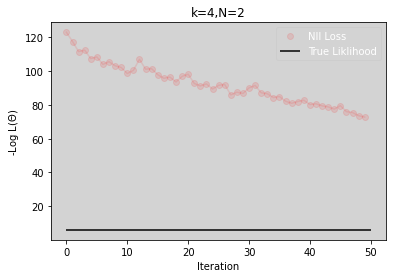

In [ ]:
plt.figure()
plt.rcParams["axes.facecolor"] = 'lightgrey'
plt.plot(emlosses2,'ro',alpha=0.1,label='Nll Loss')
plt.plot(emlosses2,"red",alpha=0.1)
plt.hlines(y=5.9566,xmin=0,xmax=50,label= 'True Liklihood')
l = plt.legend()
for text in l.get_texts():
    text.set_color("white")
plt.ylabel('-Log L($\Theta$)')
plt.xlabel('Iteration')
plt.title('k=4,N=2')
# print(emlosses)

# 新段落

In [ ]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [ ]:
# generate partial obseved data
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.optim as optim
import numpy as np
# set seed
seed = 1322
torch.manual_seed(seed)

In [ ]:
def kronecker(A,B):
    return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))
def partial_mask(sz,del_num):
    '''mask the known part and un know part'''
    kn_mask = torch.zeros(sz,sz)
    kn_mask[:-del_num,:-del_num] = 1

    un_un_mask = torch.zeros(sz,sz)
    un_un_mask[-del_num:,-del_num:] = 1
    un_un_mask = un_un_mask - torch.diag(torch.diag(un_un_mask))

    left_mask = torch.ones(sz,sz)
    left_mask[:-del_num,:-del_num] = 0
    left_mask = left_mask-torch.diag(torch.diag(left_mask))
    kn_un_mask = left_mask - un_un_mask

    return kn_mask,left_mask,un_un_mask,kn_un_mask

class kronecker_Generator(nn.Module):
    def __init__(self,korder = 3,node_num = 2):
        super(kronecker_Generator,self).__init__()
        self.p = Parameter(torch.rand(node_num,node_num,requires_grad=True))
        self.korder = korder
        # print(self.p)
    def generator_adjacency(self):
        k = self.korder
        p0 = self.p
        adj = self.p
        for i in range(k-1):
            adj = kronecker(adj,p0)
        return adj

class sample_edges():
  '''sample missing edges'''
  def __init__(self,edges,nonedges,adj_z):
    self.edges = edges
    self.nonedges = nonedges
    self.adj_z = adj_z
  def randsamplex(self):
    edges = self.edges
    x_idx = torch.randperm(self.shape[0])[0]
    x_edge = edges[x_idx]
    afteremove_edges =  torch.cat((edges[:x_idx],edges[x_idx+1:]),axis = 1)
    afteremove_nonedges = torch.cat((nonedges,x_edge),axis = 1)
    return x_edges, afteremove_edges,afteremove_nonedges
  def sampley(self):
    adj_z = self.adj_z
    x_edge,edges,nonedges = self.randsamplex()
    prob = adj_z[nonedges[:,0],nonedges[:,1]].detach().numpy()
    # 归一化
    prob = prob/prob.sum()
    length = prob.shape[0]
    y_idx = int(np.random.choice(range(legnth),p = prob.ravel()))
    y_edge = nonedges[y_idx]
    removey_nonedges = torch.cat((nonedges[:x_idx],nonedges[x_idx+1:]),axis = 1)
    addy_edges = torch.cat((edges,y_edge),axis = 1)
    return x_edge,y_edge,removey_nonedges,addy_edges
  def Metrosample(self):
    adj_z = self.adj_z
    x_edge,y_edge,removey_nonedges,addy_edges = self.sampley()
    py = adj_z[y_edge[0]][y_edge[1]]
    px = adj_z[x_edge[0]][x_edge[1]]
    u = torch.rand(1)
    ratio  = (1-py)/(1-px)
    later_adj_z = torch.clone(adj_z)
    later_adj_z[y_edge[0]][y_edge[1]] = 1
    later_adj_z[x_edge[0]][x_edge[1]] = 0
    if u < min(1,ratio):
      return addy_edges,removey_nonedges,later_adj_z
    else:
      return self.edges,self.nonedges,self.adj_z

class sample_permutation():
  def __init__(self,kron_adj,perm,object_adj):
    '''perm like tensor[1,2,3,4,5] '''
    self.kron_adj = kron_adj
    self.perm = perm
    self.object_adj = object_adj


  def samplePermutation(self):
      sz = self.kron_adj.shape[0]
      perm = self.perm
      node_list = torch.range(sz)
      swap_nodes = torch.randint(sz,(1,2)) # choose 2 nodes to swap
      idx_i,idx_j = swap_nodes[0][0],swap_nodes[0][1]
      while idx_i==idx_j:
        swap_nodes = torch.randint(sz,(1,2))
        idx_i,idx_j = swap_nodes[0][0],swap_nodes[0][1]
      later_perm = torch.clone(perm)
      later_perm[idx_i],later_perm[idx_j] = later_perm[idx_j],later_perm[idx_i]

      # get sigma_later
      p = torch.eye(sz)
      P = torch.index_select(P,0,later_perm)
      adj_later = torch.mm(torch.mm(P,self.object_adj),P.T)

      return later_perm,adj_later

  def metropolis_sample(self):
      '''
      if memory is sufficinet, this one is much cleaner to execute since we already used array operation
      otherwise, we have to update manually.
      '''
      later_perm,adj_later = self.samplePermutation()
      Nll_before=(1-self.object_adj)*torch.log(1-self.kron_adj) +self.object_adj*torch.log(self.kron_adj)
      Nll_later=(1-adj_later)*torch.log(1-Pk) +adj_later*torch.log(Pk)
      ratio=torch.exp(torch.sum(Nll_later-Nll_before))
      u = torch.rand(1)
      if u<ratio:
        return later_perm,adj_later

      return self.perm,self.object_adj

In [ ]:
# toy train data  generator
p = torch.FloatTensor([[0.9,0.7],[0.5, 0.3]])
k = 4
ground_adj = p

# 删除0.25比例的节点 origin: we randomly removed 25% of the nodes and the corresponding edges.
sz = 2**4
remove_proportion = 0.25
del_num = int(sz*remove_proportion)

for i in range(k-1):
    ground_adj = kronecker(ground_adj,p)

Ground_truth_adj = (ground_adj>torch.rand((ground_adj.shape))).float()
sigma=Ground_truth_adj

kn_mask,left_mask,un_un_mask,kn_un_mask = partial_mask(sz,del_num)
known_adj =  kn_mask*Ground_truth_adj

missing_edges = int((left_mask*Ground_truth_adj).sum())
print("missing edges num",missing_edges)



missing edges num 10


In [ ]:
def missing_label(sz,missing_percent):
     # random sample
     missing_num = int(sz*missing_percent)
     idx = torch.randperm(sz)[:missing_num]
     mask_un_obs = torch.zeros(sz,sz)
     for i in idx:
         mask_un_obs[i] = 1
         mask_un_obs[:,i:i+1] = 1
     mask_obs = 1- mask_un_obs
     return mask_un_obs,mask_obs

In [ ]:
1-mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
#run E_step


warm_up = 1
sample_l = 2
z = []
sigma = []

# fixed pk

generator = kronecker_Generator(4,2)
Pk = generator.generator_adjacency()

# initial partial z with fixed missing edges num
z_element_num = int(left_mask.sum())
z_element_shuffle = torch.randperm(z_element_num)
z_element_choice = z_element_shuffle[:missing_edges]
z_element_left = z_element_shuffle[missing_edges:]
z_element = torch.nonzero(left_mask)
init_z_edges = torch.index_select(z_element,0,z_element_choice)
init_z_nonedges = torch.index_select(z_element,0,z_element_left)
init_z_adj = torch.zeros([sz,sz])
init_z_adj[init_z_edges[:,0],init_z_edges[:,1]] = 1


# initial perm (sigma)

ori_perm = torch.randperm(sz)


edges = init_z_edges
nonedges = init_z_nonedges
adj_z = init_z_adj

permi = ori_perm

for i range(1):

  # sample z
  zi_sample = sample_edges(edges,nonedges,adj_z)
  edges,nonedges,adj_z = zi_sample.metropolis_sample()
  object_adj = known_adj+adj_z

  # sampel sigma

  permi_sample = sample_permutation(Pk,perm,object_adj)
  permi,adj_later = permi_sample.metropolis_sample()

In [ ]:
perm

tensor([ 2,  7, 15,  6,  9,  8,  5,  1, 13,  4, 14,  3, 10, 11, 12,  0])

tensor(10.)

In [ ]:
 matrix[(un_index[:,0],un_index[:,1])] = out

NameError: ignored

In [ ]:
mat = Pk*init_z_adj

In [ ]:
 p = mat[(index[:,0],index[:,1])].detach().numpy()

In [ ]:
import numpy as np

In [ ]:
 p = p/p.sum()

In [ ]:
 index = np.random.choice(list(range(7)), p=p.ravel())

In [ ]:
nonedges

1

In [ ]:
p = np.array([0.1, 0.0, 0.7, 0.2])
for i in range(100):
    index = np.random.choice([1, 2, 3, 4], p=p.ravel())
    print(index)

In [ ]:


  #  sigma_later[i,j]=sigma_before[i,j]
  #  sigma_later[j,i]=sigma_before[j,i]
  #  sigma_later[i,i]=sigma_before[j,j]
  #  sigma_later[j,j]=sigma_before[i,i]

In [ ]:
torch.rand(1)

tensor([0.2647])

In [ ]:
# E 过程
# Z 采样 permutation 采样
#  sample Z
# initial Z

# RunEStep(GibbsWarmUp, WarmUp, NSamples, LLV, DLLV);


In [ ]:
swap_nodes = torch.randint(16,(1,2))



In [ ]:
swap_nodes[0][0]
swap_nodes[0][1]

tensor(5)

In [ ]:
node_list = torch.range(0,sz)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


tensor([ 0.,  1.,  2.,  3.,  4., 14.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16.])

In [ ]:
# main 函数

Warmup = 5000

KronLL.RunKronEM(EMIter, GradIter, LrnRate, MnStep, MxStep, WarmUp, WarmUp, NSamples);
// KronEM
void TKroneckerLL::RunKronEM(const int& EMIter, const int& GradIter, double LrnRate, double MnStep, double MxStep, const int& GibbsWarmUp, const int& WarmUp, const int& NSamples, const TKronEMType& Type, const int& NMissing) {
	printf("\n----------------------------------------------------------------------\n");
	printf("Fitting graph on %d nodes, %d edges\n", int(RealNodes), int(RealEdges));
	printf("Kron iters:  %d (== %d nodes)\n\n", KronIters(), ProbMtx.GetNodes(KronIters()));

	TFltV LLV(NSamples);
	TVec<TFltV> DLLV(NSamples);
	//int count = 0;

	EMType = Type;
	MissEdges = NMissing;
	AppendIsoNodes();
	SetRndPerm();

	for(int i = 0; i < EMIter; i++) {
		printf("\n----------------------------------------------------------------------\n");
		printf("%03d EM-iter] E-Step\n", i+1);
		RunEStep(GibbsWarmUp, WarmUp, NSamples, LLV, DLLV);
		printf("\n\n");

		printf("%03d EM-iter] M-Step\n", i+1);
		double CurLL = RunMStep(LLV, DLLV, GradIter, LrnRate, MnStep, MxStep);
		printf("\n\n");

		if(DebugMode) {
			LLV.Add(CurLL);
			MtxV.Add(ProbMtx);
		}
	}

	RestoreGraph();
}


In [ ]:


def likehihod(A,Pk):
  NLL=np.sum((1-A)*np.log(1-Pk) +A*np.log(Pk))
  return NLL

def effeicient_way_ll(A,Pk):
  "which I think it is not efficient"
  Empty_graph_ll=np.sum(np.log(1-Pk))
  ll_graph= Empty_graph_ll+np.sum(A*np.log(Pk)-A*np.log((1-Pk)))
  return ll_graph



def metropolis_update_ratio(sigma_before,sigma_later,Pk):
  '''
  if memory is sufficinet, this one is much cleaner to execute
  '''
  Nll_before=(1-sigma_before)*np.log(1-Pk) +sigma_before*np.log(Pk)
  Nll_later=(1-sigma_later)*np.log(1-Pk) +sigma_later*np.log(Pk)
  ratio=np.exp(np.sum(Nll_later-Nll_before))
  return ratio

def SwapElement(sigma_before,i,j):
  i_topology=sigma_before[i,:]
  j_topology=sigma_before[j,:]
  sigma_later=np.copy(sigma_before)
  sigma_later[i,:]=j_topology
  sigma_later[j,:]=i_topology
  sigma_later[:,i]=sigma_before[:,j]
  sigma_later[:,j]=sigma_before[:,i]
  sigma_later[i,j]=sigma_before[i,j]
  sigma_later[j,i]=sigma_before[j,i]
  sigma_later[i,i]=sigma_before[j,j]
  sigma_later[j,j]=sigma_before[i,i]
  return sigma_later




def SamplePermutation(Pk,sigma,u,n1_swap,n2_swap,label_non_obs):
    sigma_later=SwapElement(sigma,n1_swap, n2_swap)
    ratio=metropolis_update_ratio(sigma,sigma_later,Pk)
    if u<ratio:
      sigma=sigma_later
      label_non_obs=SwapElement(label_non_obs,n1_swap, n2_swap)
    return sigma,label_non_obs
def SampleZ(H,Pk,label_non_obs,u):
  mat_size=len(Pk)
  edge_in_non_obs=H>0*label_non_obs
  edge_position=np.where(edge_in_non_obs)
  edge_removed=np.random.randint(len(edge_position[0]))
  px=Pk[edge_position[0][edge_removed],edge_position[1][edge_removed]]
  non_edge_in_non_obs=H<1*label_non_obs
  ##return
  py_array=non_edge_in_non_obs*Pk
  py_array=np.ravel(py_array)
  py=np.random.choice(idx, size=1, p=py_array/np.sum(py_array))
  ratio=(1-py_array[py])/(1-px)
  if ratio<u:

    H[py//mat_size,py%mat_size]=1
    H[edge_position[0][edge_removed],edge_position[1][edge_removed]]=0
    print('accept')
  return H


def E_step(sigma,N,Pk,label_non_obs):
  u1=np.random.rand(N)
  u2=np.random.rand(N)
  sigma_hist=[]
  Z_label=[]
  Node_list=np.arange(len(Pk))
  element_to_swap=np.random.choice(a=Node_list,size=(2,3*N))
  mask=element_to_swap[1,:]!=element_to_swap[0,:]# it is pointless to swap the same element
  n1_swap=element_to_swap[0,:][mask]
  n2_swap=element_to_swap[1,:][mask]
  for i in range(N):
    print(i)
    sigma=SampleZ(H,Pk,label_non_obs,u1[i])
    sigma,label_non_obs=SamplePermutation(Pk,sigma,u2[i],n1_swap,n2_swap,label_non_obs)
    sigma_hist.append(sigma)
    Z_label.append(label_non_obs)
  return sigma,Z_label


In [ ]:
Node_list=np.arange(16)
N = 1
element_to_swap=np.random.choice(a=Node_list,size=(2,3*N))

In [ ]:
element_to_swap

array([[13, 11,  0],
       [ 5,  8, 11]])

NameError: ignored

In [ ]:
element_to_swap[1,:][]

8

In [ ]:
p0 = torch.randn([2,2])
print(p0)

tensor([[ 0.6767,  1.8540],
        [-2.2976,  0.4554]])


In [ ]:
import numpy as np

In [ ]:
a = np.random.rand(2,2)

In [ ]:
torch.FloatTensor(a)

tensor([[0.7985, 0.7902],
        [0.8652, 0.4184]])

In [ ]:
c=np.ravel(a)

In [ ]:
c[7]

0.976900573099387

In [ ]:
a[7//5, 7%5]

0.976900573099387

In [ ]:
sz = 10

In [ ]:
py=np.random.choice(idx, size=1, p=py_array/np.sum(py_array))

In [ ]:
a

In [ ]:
import numpy as np

In [ ]:
sigma = np.eye(sz)
perm = np.take(sigma,np.random.permutation(sigma.shape[0]),axis=0,out=sigma);
sigma = np.matmul(perm.transpose(),perm)

In [ ]:
perm

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
np.matmul(perm,perm.transpose())

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
A = torch.randn([3, 3])

In [ ]:
A.expand(3,3,3)

tensor([[[-0.6794,  0.6465,  0.5300],
         [-0.9698,  0.4951,  1.5421],
         [-0.6291,  0.6542,  0.6356]],

        [[-0.6794,  0.6465,  0.5300],
         [-0.9698,  0.4951,  1.5421],
         [-0.6291,  0.6542,  0.6356]],

        [[-0.6794,  0.6465,  0.5300],
         [-0.9698,  0.4951,  1.5421],
         [-0.6291,  0.6542,  0.6356]]])

In [ ]:
A.sum()

tensor(2.2252)